In [2]:
# random forest model experiments with the permanent and temporary wetlands from the Bansal data

import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import warnings
import numpy as np
import datetime
import shap

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
from sklearn.model_selection import LeaveOneGroupOut

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/Users/lauralayton/Downloads/Chamber_GAM_model_data 2.csv')

In [6]:
df['chamber_ID'].unique()

array([1, 2, 3, 4, 5])

In [8]:
df['chamber_ID'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
18798    False
18799    False
18800    False
18801    False
18802    False
Name: chamber_ID, Length: 18803, dtype: bool

In [6]:
# Adding Month and Year columns to the data
# dates = df.iloc[:,1].values

def convert(date_time):
    format = '%m/%d/%Y'
    datetime_str = datetime.datetime.strptime(date_time, format)

    return datetime_str

df['Date Object'] = pd.to_datetime(df['Date'])
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Year'] = pd.to_datetime(df['Date']).dt.year

In [8]:
# Create a subset of df containing only data from permanent and temporary wetlands 
permanent_wetlands = ['P1', 'P3', 'P4', 'P6', 'P7', 'P8']
temporary_wetlands = ['T2', 'T3', 'T5', 'T6', 'T7', 'T8', 'T9']

perm_temp_wetlands = list(set(permanent_wetlands).union(temporary_wetlands))

# call the dataframe containing permanent and temporary wetlands 'df_pt', p for permament and t for temporary
df_pt = df[df['wetland_ID'].isin(perm_temp_wetlands)]

In [16]:
# Add an indicator for permanent wetland (i.e. 1 for permanent, 0 for temporary)
def perm_ind(wetland_ID):
    if wetland_ID[0] == "P":
        return 1
    else:
        return 0

df_pt['PERMANENT_IND'] = df['wetland_ID'].apply(perm_ind)

In [17]:
df_pt.info()

# okay so we've kept about 25% of the data
# not bad, since we are only keeping 13 of the 143 wetlands from the Bansal data

<class 'pandas.core.frame.DataFrame'>
Index: 4942 entries, 13476 to 18802
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   chamber_ID                 4942 non-null   int64         
 1   Date                       4942 non-null   object        
 2   GS_Interval_fld            4942 non-null   object        
 3   Hydroperiod_days_fld       4942 non-null   float64       
 4   LAB_ID                     4942 non-null   float64       
 5   Land_Cover_fld             4942 non-null   object        
 6   methane_flux_log_mg_m2_hr  4942 non-null   float64       
 7   NDVI_lag_rs                4942 non-null   float64       
 8   NDVI_rs                    4942 non-null   float64       
 9   Size_m2_fld                4942 non-null   float64       
 10  SoilT_C_fld                4942 non-null   float64       
 11  SoilT_lag_C_fld            4942 non-null   float64       
 12  Water_

In [33]:
label_encoder = LabelEncoder()

## Temporal Split

Using 2009-2015 (inclusive) as training data and 2016 as the test data set

R-squared, no max depth, temporal split: -0.05107542729919534


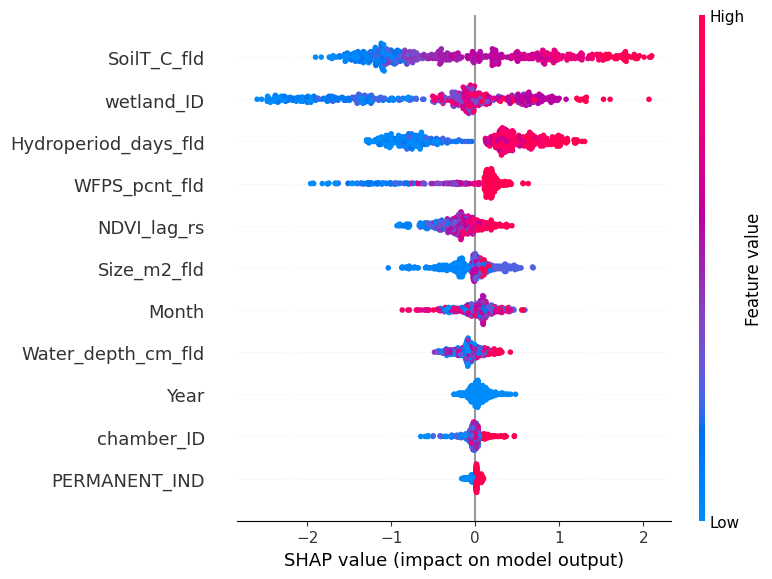

In [71]:
df_temporal_train = df_pt[df_pt['Year'] < 2016]
df_temporal_test = df_pt[df_pt['Year'] > 2015]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND', 'wetland_ID']

X_temporal_train = df_temporal_train[feature_list]
X_temporal_test = df_temporal_test[feature_list]

y_temporal_train = df_temporal_train['methane_flux_log_mg_m2_hr']
y_temporal_test = df_temporal_test['methane_flux_log_mg_m2_hr']

# normally: convert categorical features to numerical for regression
# however, all of the included features are already numerical
x_temporal_train_categorical = X_temporal_train.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_temporal_train_numerical = X_temporal_train.select_dtypes(exclude = ['object'])

X_temporal_train = pd.concat([x_temporal_train_categorical, x_temporal_train_numerical], axis = 1)

x_temporal_test_categorical = X_temporal_test.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_temporal_test_numerical = X_temporal_test.select_dtypes(exclude = ['object'])

X_temporal_test = pd.concat([x_temporal_test_categorical, x_temporal_test_numerical], axis = 1)

regressor_temporal = RandomForestRegressor(oob_score = True)

regressor_temporal.fit(X_temporal_train, y_temporal_train)

predictions_temporal = regressor_temporal.predict(X_temporal_test)
print(f'R-squared, no max depth, temporal split: {r2_score(y_temporal_test, predictions_temporal)}')

# SHAP plot
explainer_temporal = shap.Explainer(regressor_temporal)

shap_values_temporal = explainer_temporal.shap_values(X_temporal_test)
shap.summary_plot(shap_values_temporal, X_temporal_test)


Training on 2009-2014, and testing on 2015, 2016

R-squared, no max depth, temporal split: 0.42165546854912805


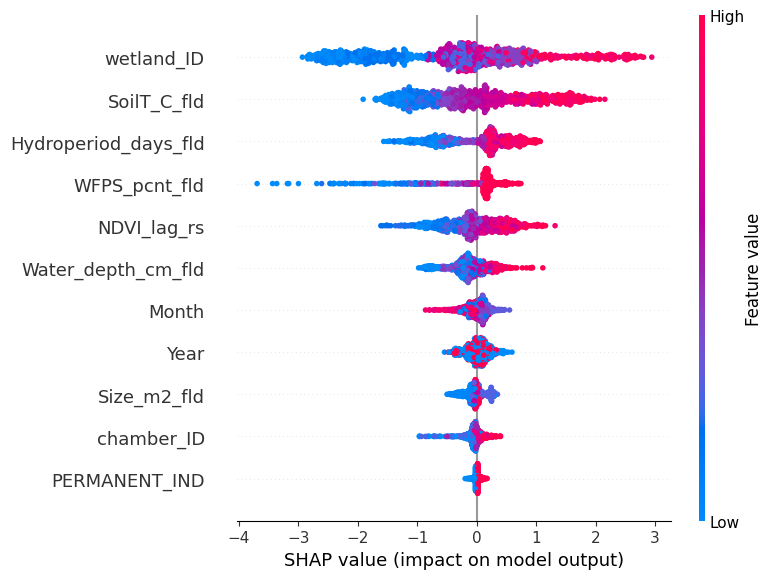

In [47]:
df_temporal_train = df_pt[df_pt['Year'] < 2015]
df_temporal_test = df_pt[df_pt['Year'] > 2014]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND', 'wetland_ID']

X_temporal_train = df_temporal_train[feature_list]
X_temporal_test = df_temporal_test[feature_list]

y_temporal_train = df_temporal_train['methane_flux_log_mg_m2_hr']
y_temporal_test = df_temporal_test['methane_flux_log_mg_m2_hr']

# normally: convert categorical features to numerical for regression
# however, all of the included features are already numerical
x_temporal_train_categorical = X_temporal_train.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_temporal_train_numerical = X_temporal_train.select_dtypes(exclude = ['object'])

X_temporal_train = pd.concat([x_temporal_train_categorical, x_temporal_train_numerical], axis = 1)

x_temporal_test_categorical = X_temporal_test.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_temporal_test_numerical = X_temporal_test.select_dtypes(exclude = ['object'])

X_temporal_test = pd.concat([x_temporal_test_categorical, x_temporal_test_numerical], axis = 1)

regressor_temporal = RandomForestRegressor(oob_score = True)

regressor_temporal.fit(X_temporal_train, y_temporal_train)

predictions_temporal = regressor_temporal.predict(X_temporal_test)
print(f'R-squared, no max depth, temporal split: {r2_score(y_temporal_test, predictions_temporal)}')

# SHAP plot
explainer_temporal = shap.Explainer(regressor_temporal)

shap_values_temporal = explainer_temporal.shap_values(X_temporal_test)
shap.summary_plot(shap_values_temporal, X_temporal_test)


Try without wetland_id, which is suspiciously important in the SHAP plot above

Out-of-Bag Score: 0.7108856472195092
R-squared, no max depth, temporal split: 0.4142025665716781


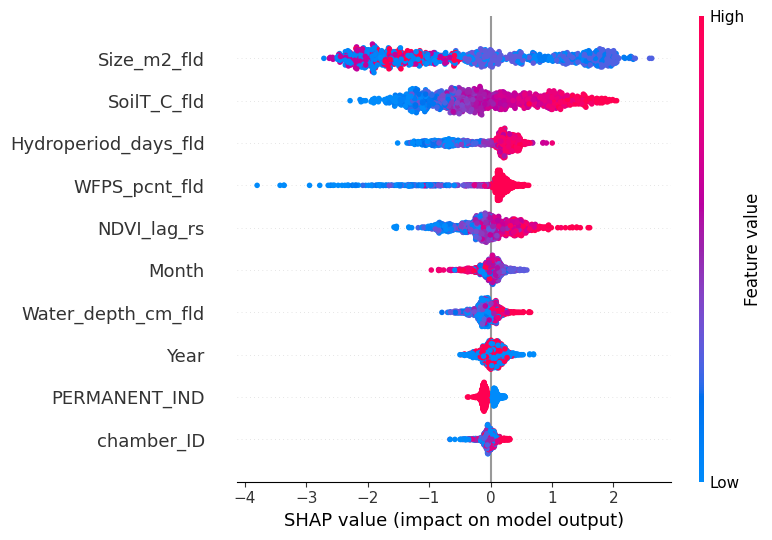

In [53]:
df_temporal_train = df_pt[df_pt['Year'] < 2015]
df_temporal_test = df_pt[df_pt['Year'] > 2014]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND']

X_temporal_train = df_temporal_train[feature_list]
X_temporal_test = df_temporal_test[feature_list]

y_temporal_train = df_temporal_train['methane_flux_log_mg_m2_hr']
y_temporal_test = df_temporal_test['methane_flux_log_mg_m2_hr']

regressor_temporal = RandomForestRegressor(oob_score = True)

regressor_temporal.fit(X_temporal_train, y_temporal_train)

oob_score = regressor_temporal.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions_temporal = regressor_temporal.predict(X_temporal_test)
print(f'R-squared, no max depth, temporal split: {r2_score(y_temporal_test, predictions_temporal)}')

# SHAP plot
explainer_temporal = shap.Explainer(regressor_temporal)

shap_values_temporal = explainer_temporal.shap_values(X_temporal_test)
shap.summary_plot(shap_values_temporal, X_temporal_test)


Training on 2009-2013, and testing on 2014-2016

Out-of-Bag Score: 0.7142134811728211
R-squared, no max depth, temporal split: 0.4301285543194572


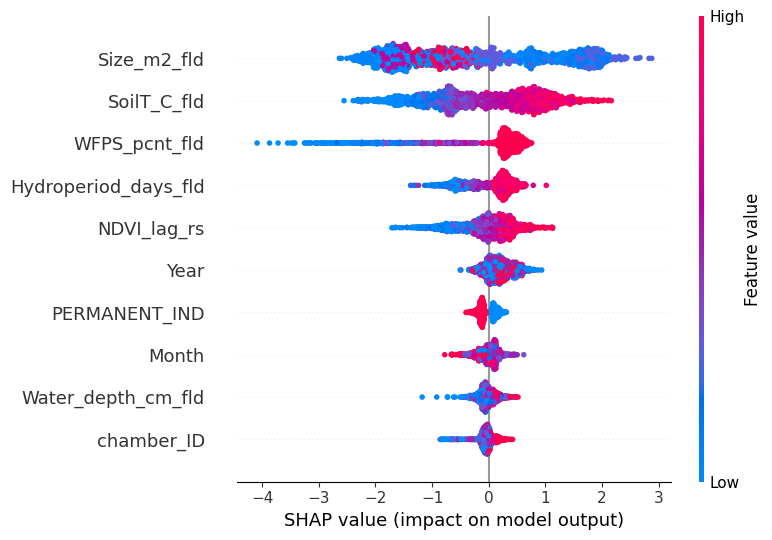

In [69]:
df_temporal_train = df_pt[df_pt['Year'] < 2014]
df_temporal_test = df_pt[df_pt['Year'] > 2013]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND']

X_temporal_train = df_temporal_train[feature_list]
X_temporal_test = df_temporal_test[feature_list]

y_temporal_train = df_temporal_train['methane_flux_log_mg_m2_hr']
y_temporal_test = df_temporal_test['methane_flux_log_mg_m2_hr']

regressor_temporal = RandomForestRegressor(oob_score = True)

regressor_temporal.fit(X_temporal_train, y_temporal_train)

oob_score = regressor_temporal.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions_temporal = regressor_temporal.predict(X_temporal_test)
print(f'R-squared, no max depth, temporal split: {r2_score(y_temporal_test, predictions_temporal)}')

# SHAP plot
explainer_temporal = shap.Explainer(regressor_temporal)

shap_values_temporal = explainer_temporal.shap_values(X_temporal_test)
shap.summary_plot(shap_values_temporal, X_temporal_test)


Training on 2009-2012 and testing on 2013-2016

Out-of-Bag Score: 0.729345391875379
R-squared, no max depth, temporal split: 0.3486247205577345


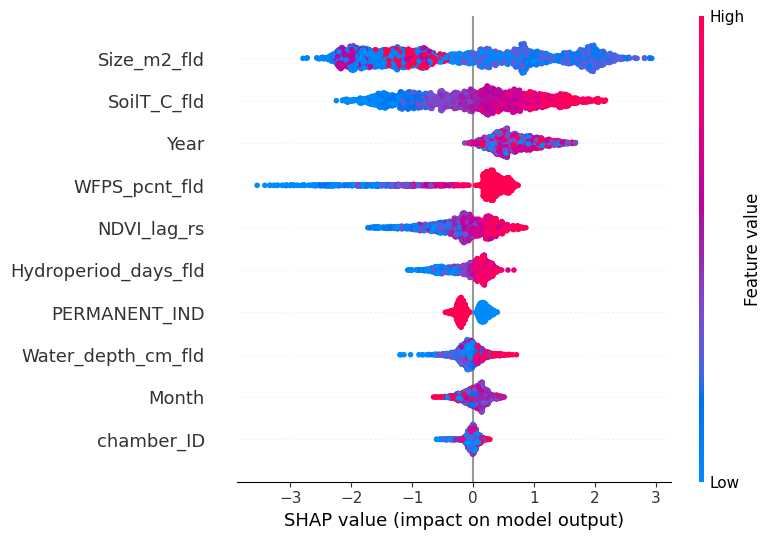

In [76]:
df_temporal_train = df_pt[df_pt['Year'] < 2013]
df_temporal_test = df_pt[df_pt['Year'] > 2012]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND']

X_temporal_train = df_temporal_train[feature_list]
X_temporal_test = df_temporal_test[feature_list]

y_temporal_train = df_temporal_train['methane_flux_log_mg_m2_hr']
y_temporal_test = df_temporal_test['methane_flux_log_mg_m2_hr']

regressor_temporal = RandomForestRegressor(oob_score = True)

regressor_temporal.fit(X_temporal_train, y_temporal_train)

oob_score = regressor_temporal.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions_temporal = regressor_temporal.predict(X_temporal_test)
print(f'R-squared, no max depth, temporal split: {r2_score(y_temporal_test, predictions_temporal)}')

# SHAP plot
explainer_temporal = shap.Explainer(regressor_temporal)

shap_values_temporal = explainer_temporal.shap_values(X_temporal_test)
shap.summary_plot(shap_values_temporal, X_temporal_test)


Training on 2010-2016 and testing on 2009

Out-of-Bag Score: 0.6904123236585248
R-squared, no max depth, temporal split: 0.4510390587360802


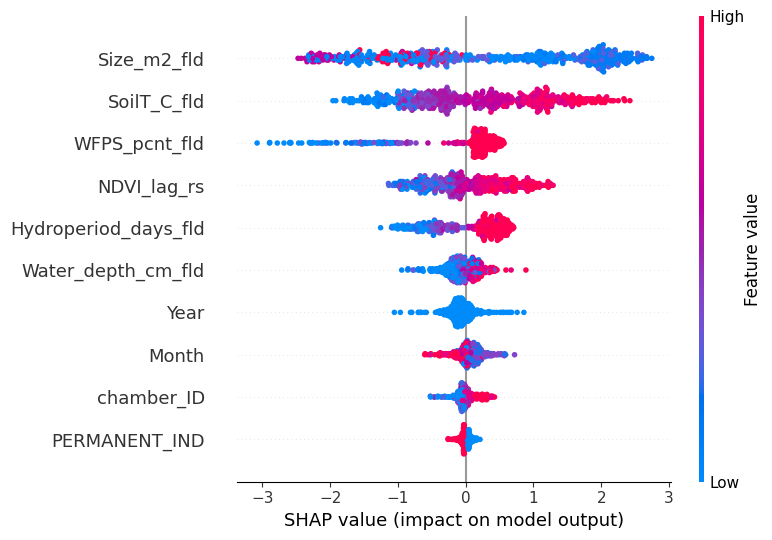

In [77]:
df_temporal_train = df_pt[df_pt['Year'] > 2009]
df_temporal_test = df_pt[df_pt['Year'] == 2009]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND']

X_temporal_train = df_temporal_train[feature_list]
X_temporal_test = df_temporal_test[feature_list]

y_temporal_train = df_temporal_train['methane_flux_log_mg_m2_hr']
y_temporal_test = df_temporal_test['methane_flux_log_mg_m2_hr']

regressor_temporal = RandomForestRegressor(oob_score = True)

regressor_temporal.fit(X_temporal_train, y_temporal_train)

oob_score = regressor_temporal.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions_temporal = regressor_temporal.predict(X_temporal_test)
print(f'R-squared, no max depth, temporal split: {r2_score(y_temporal_test, predictions_temporal)}')

# SHAP plot
explainer_temporal = shap.Explainer(regressor_temporal)

shap_values_temporal = explainer_temporal.shap_values(X_temporal_test)
shap.summary_plot(shap_values_temporal, X_temporal_test)


### Same as above, but removing Size_m2_fld

Out-of-Bag Score: 0.5855784341850021
R-squared, no max depth, temporal split: 0.3263735580506735


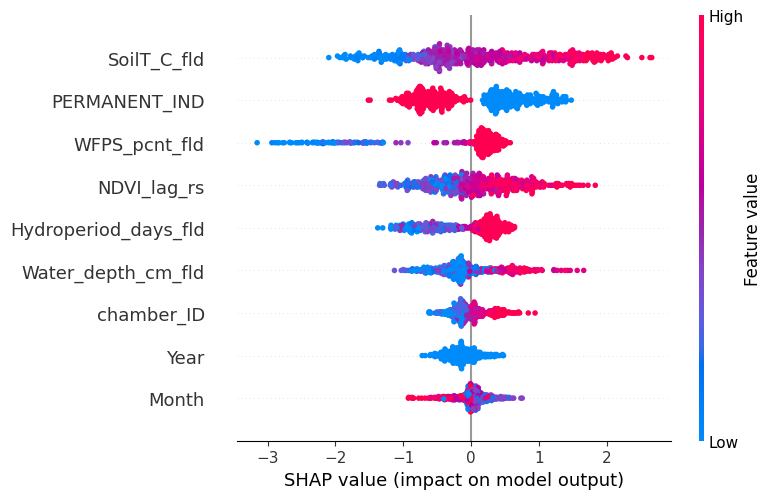

In [75]:
df_temporal_train = df_pt[df_pt['Year'] > 2009]
df_temporal_test = df_pt[df_pt['Year'] == 2009]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND']

X_temporal_train = df_temporal_train[feature_list]
X_temporal_test = df_temporal_test[feature_list]

y_temporal_train = df_temporal_train['methane_flux_log_mg_m2_hr']
y_temporal_test = df_temporal_test['methane_flux_log_mg_m2_hr']

regressor_temporal = RandomForestRegressor(oob_score = True)

regressor_temporal.fit(X_temporal_train, y_temporal_train)

oob_score = regressor_temporal.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions_temporal = regressor_temporal.predict(X_temporal_test)
print(f'R-squared, no max depth, temporal split: {r2_score(y_temporal_test, predictions_temporal)}')

# SHAP plot
explainer_temporal = shap.Explainer(regressor_temporal)

shap_values_temporal = explainer_temporal.shap_values(X_temporal_test)
shap.summary_plot(shap_values_temporal, X_temporal_test)


Removing size as a feature, training/test split of 2009-2014/2015-2016

Out-of-Bag Score: 0.6017792050561381
R-squared, no max depth, temporal split: 0.19186743434796993


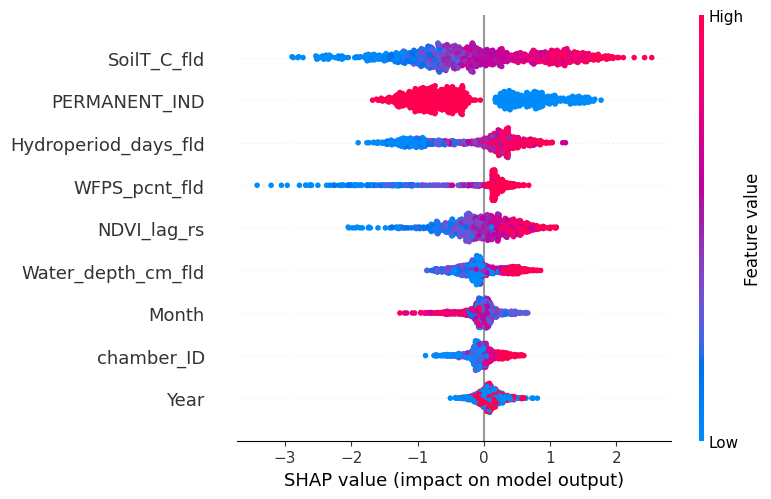

In [79]:
df_temporal_train = df_pt[df_pt['Year'] < 2015]
df_temporal_test = df_pt[df_pt['Year'] > 2014]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND']

X_temporal_train = df_temporal_train[feature_list]
X_temporal_test = df_temporal_test[feature_list]

y_temporal_train = df_temporal_train['methane_flux_log_mg_m2_hr']
y_temporal_test = df_temporal_test['methane_flux_log_mg_m2_hr']

regressor_temporal = RandomForestRegressor(oob_score = True)

regressor_temporal.fit(X_temporal_train, y_temporal_train)

oob_score = regressor_temporal.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions_temporal = regressor_temporal.predict(X_temporal_test)
print(f'R-squared, no max depth, temporal split: {r2_score(y_temporal_test, predictions_temporal)}')

# SHAP plot
explainer_temporal = shap.Explainer(regressor_temporal)

shap_values_temporal = explainer_temporal.shap_values(X_temporal_test)
shap.summary_plot(shap_values_temporal, X_temporal_test)


### Maybe 2016 is an outlier year? Try excluding it

Out-of-Bag Score: 0.7135424421787483
R-squared, no max depth, temporal split: 0.5151211784481936


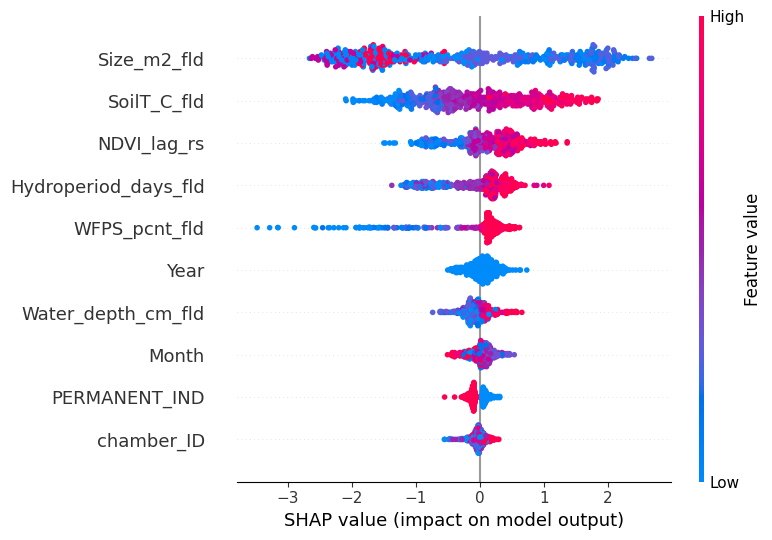

In [81]:
df_temporal_train = df_pt[df_pt['Year'] < 2015]
df_temporal_test = df_pt[df_pt['Year'] == 2015]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND']

X_temporal_train = df_temporal_train[feature_list]
X_temporal_test = df_temporal_test[feature_list]

y_temporal_train = df_temporal_train['methane_flux_log_mg_m2_hr']
y_temporal_test = df_temporal_test['methane_flux_log_mg_m2_hr']

regressor_temporal = RandomForestRegressor(oob_score = True)

regressor_temporal.fit(X_temporal_train, y_temporal_train)

oob_score = regressor_temporal.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions_temporal = regressor_temporal.predict(X_temporal_test)
print(f'R-squared, no max depth, temporal split: {r2_score(y_temporal_test, predictions_temporal)}')

# SHAP plot
explainer_temporal = shap.Explainer(regressor_temporal)

shap_values_temporal = explainer_temporal.shap_values(X_temporal_test)
shap.summary_plot(shap_values_temporal, X_temporal_test)


Excluding 2016 and Size_m2_fld

Out-of-Bag Score: 0.594377630033935
R-squared, no max depth, temporal split: 0.33112545990704


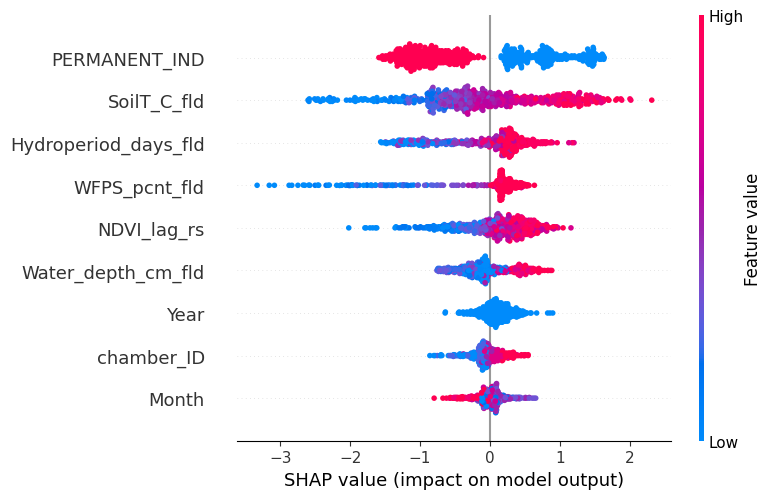

In [82]:
df_temporal_train = df_pt[df_pt['Year'] < 2015]
df_temporal_test = df_pt[df_pt['Year'] == 2015]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND']

X_temporal_train = df_temporal_train[feature_list]
X_temporal_test = df_temporal_test[feature_list]

y_temporal_train = df_temporal_train['methane_flux_log_mg_m2_hr']
y_temporal_test = df_temporal_test['methane_flux_log_mg_m2_hr']

regressor_temporal = RandomForestRegressor(oob_score = True)

regressor_temporal.fit(X_temporal_train, y_temporal_train)

oob_score = regressor_temporal.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions_temporal = regressor_temporal.predict(X_temporal_test)
print(f'R-squared, no max depth, temporal split: {r2_score(y_temporal_test, predictions_temporal)}')

# SHAP plot
explainer_temporal = shap.Explainer(regressor_temporal)

shap_values_temporal = explainer_temporal.shap_values(X_temporal_test)
shap.summary_plot(shap_values_temporal, X_temporal_test)


Try using K-folds

Just try the oob thing with all the data

In [58]:
X = df_pt[feature_list]
y = df_pt['methane_flux_log_mg_m2_hr']

# x_categorical = X.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
# x_numerical = X.select_dtypes(exclude = ['object'])

# X = pd.concat([x_categorical, x_numerical], axis = 1)

rf = RandomForestRegressor(oob_score=True)
rf.fit(X, y)

# Get the OOB score
oob_score = rf.oob_score_
print(f"OOB Score: {oob_score:.4f}")

OOB Score: 0.6978


## Spatial Split

R-squared, no max depth, spatial split: 0.12693680775735294


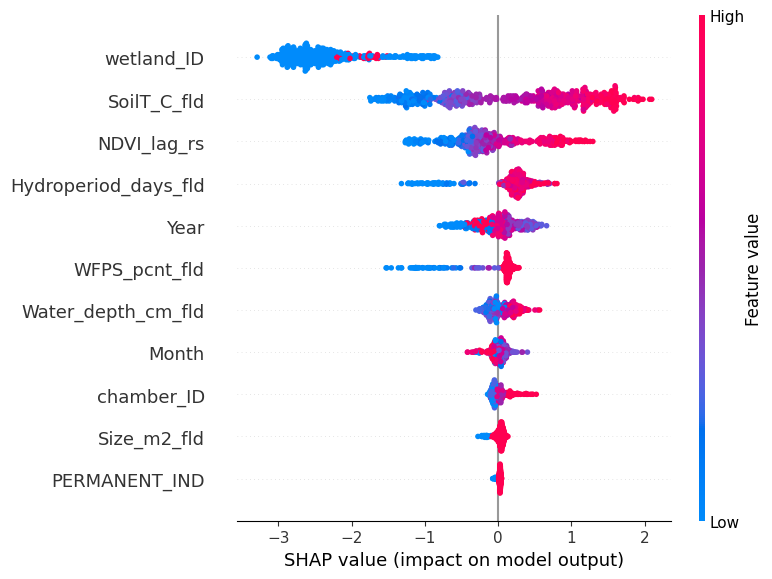

In [68]:
test_wetlands = ['T2', 'P4']

df_spatial_train = df_pt[~df_pt['wetland_ID'].isin(test_wetlands)]
df_spatial_test = df_pt[df_pt['wetland_ID'].isin(test_wetlands)]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND', 'wetland_ID']

X_spatial_train = df_spatial_train[feature_list]
X_spatial_test = df_spatial_test[feature_list]

y_spatial_train = df_spatial_train['methane_flux_log_mg_m2_hr']
y_spatial_test = df_spatial_test['methane_flux_log_mg_m2_hr']

# normally: convert categorical features to numerical for regression
# however, all of the included features are already numerical
x_spatial_train_categorical = X_spatial_train.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_spatial_train_numerical = X_spatial_train.select_dtypes(exclude = ['object'])

X_spatial_train = pd.concat([x_spatial_train_categorical, x_spatial_train_numerical], axis = 1)

x_spatial_test_categorical = X_spatial_test.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_spatial_test_numerical = X_spatial_test.select_dtypes(exclude = ['object'])

X_spatial_test = pd.concat([x_spatial_test_categorical, x_spatial_test_numerical], axis = 1)

regressor_spatial = RandomForestRegressor(oob_score = True)

regressor_spatial.fit(X_spatial_train, y_spatial_train)

predictions_spatial = regressor_spatial.predict(X_spatial_test)
print(f'R-squared, no max depth, spatial split: {r2_score(y_spatial_test, predictions_spatial)}')

# SHAP plot
explainer_spatial = shap.Explainer(regressor_spatial)

shap_values_spatial = explainer_spatial.shap_values(X_spatial_test)
shap.summary_plot(shap_values_spatial, X_spatial_test)


R-squared, no max depth, spatial split: 0.12386208241269236


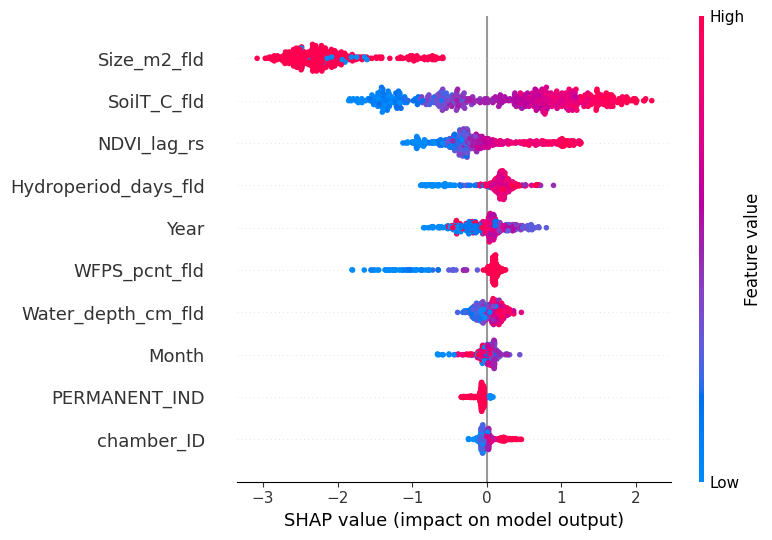

In [63]:
test_wetlands = ['P4', 'T2']

df_spatial_train = df_pt[~df_pt['wetland_ID'].isin(test_wetlands)]
df_spatial_test = df_pt[df_pt['wetland_ID'].isin(test_wetlands)]

# features to include: chamber ID, year, month, hydroperiod, land cover, NDVI lag, size, soil temp, water depth, WFPS, permanent indicator
# do not use wetland ID as a feature, just the indicator for being a permanent wetland
# do not use Land_Cover_fld, since the only value in df_pt is 'Grass'
feature_list = ['chamber_ID', 'Year', 'Month', 'Hydroperiod_days_fld', 
        'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'PERMANENT_IND']

X_spatial_train = df_spatial_train[feature_list]
X_spatial_test = df_spatial_test[feature_list]

y_spatial_train = df_spatial_train['methane_flux_log_mg_m2_hr']
y_spatial_test = df_spatial_test['methane_flux_log_mg_m2_hr']

regressor_spatial = RandomForestRegressor(oob_score = True)

regressor_spatial.fit(X_spatial_train, y_spatial_train)

predictions_spatial = regressor_spatial.predict(X_spatial_test)
print(f'R-squared, no max depth, spatial split: {r2_score(y_spatial_test, predictions_spatial)}')

# SHAP plot
explainer_spatial = shap.Explainer(regressor_spatial)

shap_values_spatial = explainer_spatial.shap_values(X_spatial_test)
shap.summary_plot(shap_values_spatial, X_spatial_test)
